In [1]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
from OptimumFilter import *


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
sub_template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)


In [2]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='NR',
            quantize=True,
            phonon_only=False,
            long_trace_samples = 50000
        )
trace = trace[0]

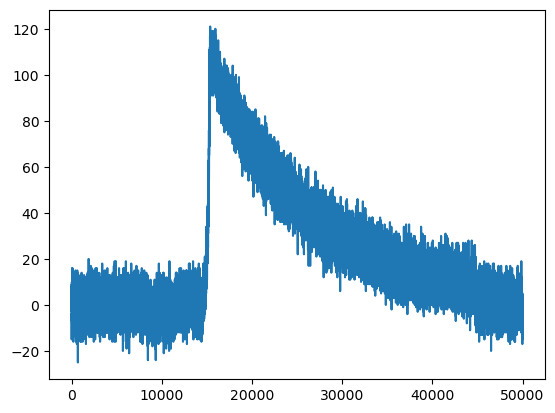

In [3]:
example = trace[7]
plt.plot(example)

In [4]:
idx

12042

In [5]:
ampl, chisq = sub_of.fit(example[0:32768])

In [6]:
ampl

-30.3441729455594

In [7]:
chisq

1.4518071289717338

In [8]:
from joblib import Parallel, delayed
import numpy as np

trace = example  # assuming example is a 1D array of length 50000
window_size = 32768
num_windows = len(trace) - window_size + 1

def fit_window(i):
    segment = trace[i:i+window_size]
    return sub_of.fit(segment)

results = Parallel(n_jobs=-1)(delayed(fit_window)(i) for i in range(num_windows))
ampl_arr, chisq_arr = map(np.array, zip(*results))


12042


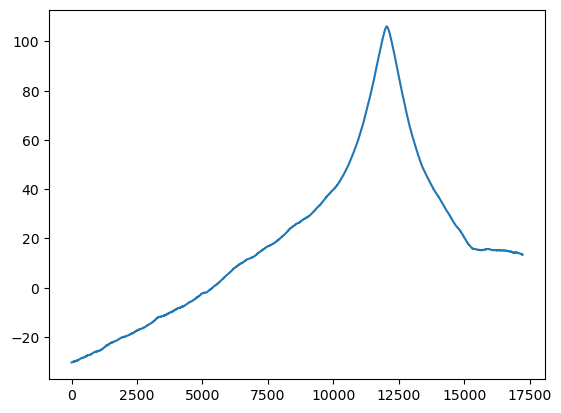

In [14]:
plt.plot(ampl_arr)
print(np.argmax(ampl_arr))

12042


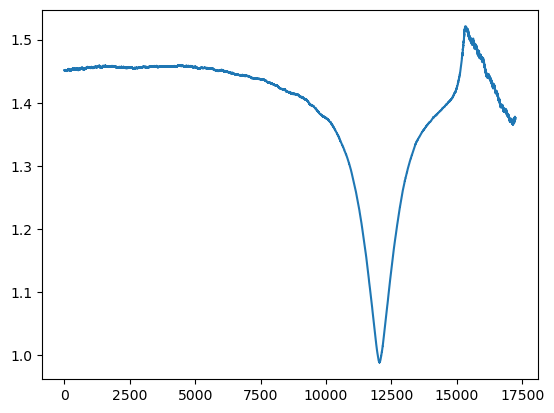

In [16]:
plt.plot(chisq_arr)
print(np.argmin(chisq_arr))

In [11]:
idx

12042

In [17]:
np.savez("validation_trace.npz", raw=example, ampl=ampl_arr, chisq=chisq_arr, inject=idx)
